# Project-2 
`Diana Zhang`, `Bruno Ivasic`, `Kerry Zhang`, `Prajwal Patnaik`

### Loading Libraries

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# Using seaborn to plot the Backtesting heatmaps
import seaborn as sns
import hvplot.pandas
import datetime as dt
import holoviews as hv
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import the finta Python library and the TA module
from finta import TA

# Import the backtesting libraries and modules
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover

%matplotlib inline

C:\Users\prajw\Anaconda3\envs\dev\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Defining Global Variables

In [2]:
# Define Start Date and End Date of the historical data.
# Start Date is five years prior

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=1825)

In [3]:
# Choosing the stock ticker
stock_symbol = 'PEP'

### Importing Data

In [4]:
# Fetch historical price data for the specified stock using yfinance
stock_hd_df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Ensuring the index is in date time format
stock_hd_df.index = pd.to_datetime(stock_hd_df.index, format='mixed', infer_datetime_format=True)

In [6]:
# Review the dataframe
display(stock_hd_df.head())
display(stock_hd_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-19,112.629997,113.190002,109.629997,110.040001,95.523926,6915400
2018-12-20,110.199997,111.930000,109.199997,110.209999,95.671478,8468300
2018-12-21,110.959999,114.160004,108.809998,109.419998,94.985695,13263600
2018-12-24,110.129997,111.089996,105.959999,106.029999,92.042900,3354000
2018-12-26,106.220001,108.440002,105.029999,108.330002,94.039482,4537000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-11,167.440002,168.130005,166.460007,167.820007,167.820007,6912600
2023-12-12,169.279999,169.279999,167.710007,168.470001,168.470001,4515800
2023-12-13,168.539993,172.050003,168.119995,172.009995,172.009995,6082100
2023-12-14,171.649994,171.970001,167.940002,168.250000,168.250000,7119300
2023-12-15,167.449997,168.509995,166.449997,167.000000,167.000000,17731300


## DMAC (Dual-Moving Average Crossover) Trading Algorithm - Optimisation

In [7]:
df = stock_hd_df.copy().dropna()
df.index.names = ["date"]
df.reset_index(inplace=True)
df.set_index('date', inplace=True) # set index on the date column, which is requirement to sort it by time periods
df.head()

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2018-12-19,112.629997,113.190002,109.629997,110.040001,95.523926,6915400
2018-12-20,110.199997,111.930000,109.199997,110.209999,95.671478,8468300
2018-12-21,110.959999,114.160004,108.809998,109.419998,94.985695,13263600
2018-12-24,110.129997,111.089996,105.959999,106.029999,92.042900,3354000
2018-12-26,106.220001,108.440002,105.029999,108.330002,94.039482,4537000


In [8]:
# Apply the ohlc() method on the Series to automatically format the dataframe in the format expected by the TA / backtest library
ohlc = df['Close'].resample('24h').ohlc() # select only price column, resample by time period and return daily ohlc
ohlc.head()

,open,high,low,close
date,,,,
2018-12-19,110.040001,110.040001,110.040001,110.040001
2018-12-20,110.209999,110.209999,110.209999,110.209999
2018-12-21,109.419998,109.419998,109.419998,109.419998
2018-12-22,NaN,NaN,NaN,NaN
2018-12-23,NaN,NaN,NaN,NaN


In [9]:
# Add in upper case columns expected and needed by TA library
ohlc["Open"] = stock_hd_df["Open"]
ohlc["High"] = stock_hd_df["High"]
ohlc["Low"] = stock_hd_df["Low"]
ohlc["Close"] = stock_hd_df["Close"]
ohlc["Volume"] = stock_hd_df["Volume"]
ohlc["volume"] = stock_hd_df["Volume"]

ohlc.head()

,open,high,low,close,Open,High,Low,Close,Volume,volume
date,,,,,,,,,,
2018-12-19,110.040001,110.040001,110.040001,110.040001,112.629997,113.190002,109.629997,110.040001,6915400.0,6915400.0
2018-12-20,110.209999,110.209999,110.209999,110.209999,110.199997,111.930000,109.199997,110.209999,8468300.0,8468300.0
2018-12-21,109.419998,109.419998,109.419998,109.419998,110.959999,114.160004,108.809998,109.419998,13263600.0,13263600.0
2018-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Drop any nulls
ohlc.dropna(inplace=True)

In [11]:
# Define the DMAC Strategy Class for use with Backtesting

# Overcome an issue with the backtesting 
# RuntimeError: Indicator "DEMA(df,10)" errored with exception: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
# https://github.com/peerchemist/finta/issues/102 
def convert_finta(df: pd.DataFrame) -> pd.DataFrame:
    df_finta = pd.DataFrame()
    df_finta["open"] = df["open"]
    df_finta["high"] = df["high"]
    df_finta["low"] = df["low"]
    df_finta["close"] = df["close"]
    df_finta["volume"] = df["volume"] 
    return df_finta


# Define a DMAC (Dual-Moving Average Cross-over) strategy for Backtesting.
class DmaCrossStrategy(Strategy):
    # Initialise local variables
    # Define the two EMA lags as *class variables*
    # for later optimisation
    short_window = 20
    long_window = 80
    
    def init(self):
        # Precompute two moving averages
        self.ema_fast = self.I(TA.EMA, convert_finta(ohlc), self.short_window)
        self.ema_slow = self.I(TA.EMA, convert_finta(ohlc), self.long_window)

    def next(self):       
        if crossover(self.ema_fast, self.ema_slow):   # If the short window crosses over the long window then...
            self.position.close()                            #   close any open positions
            self.buy()                                       #   generate a buy signal
        else:                                                # else
            ### TO DO: Many xMA crossover strategies check that the slow crosses the short
            self.position.close()                            #   close any open positions
            self.sell()                                      #   generate a sell signal

In [12]:
# Instantiate a single run simulation with the DMAC Strategy
bt = Backtest(ohlc, DmaCrossStrategy, cash=10000, commission=0.0)

In [13]:
# Run the simulation
bt.run()

Start                     2018-12-19 00:00:00
End                       2023-12-15 00:00:00
Duration                   1822 days 00:00:00
Exposure Time [%]                   99.840891
Equity Final [$]                  5253.957672
Equity Peak [$]                  10447.800026
Return [%]                         -47.460423
Buy & Hold Return [%]               51.762994
Return (Ann.) [%]                  -12.105056
Volatility (Ann.) [%]               19.290704
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -56.369784
Avg. Drawdown [%]                  -56.369784
Max. Drawdown Duration     1817 days 00:00:00
Avg. Drawdown Duration     1817 days 00:00:00
# Trades                                 1255
Win Rate [%]                        46.932271
Best Trade [%]                      10.351825
Worst Trade [%]                     -5.314177
Avg. Trade [%]                    

In [14]:
# Call Optimize with a range of parameters which it will iterate over
stats, heatmap = bt.optimize(           # Run the optimizer...
        short_window = range(2,30,2),   # Test a range of options for the short window bound starting from 2 to 30 in increments of 2
        long_window = range(40,90,2),   # Test a range of options for the short window bound starting from 40 to 90 in increments of 2
        maximize='Equity Final [$]',
        return_heatmap=True)


C:\Users\prajw\Anaconda3\envs\dev\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 350 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

<Strategy DmaCrossStrategy(short_window=8,long_window=68)>

Start                     2018-12-19 00:00:00
End                       2023-12-15 00:00:00
Duration                   1822 days 00:00:00
Exposure Time [%]                   99.840891
Equity Final [$]                  6773.729156
Equity Peak [$]                  10537.939514
Return [%]                         -32.262708
Buy & Hold Return [%]               51.762994
Return (Ann.) [%]                   -7.512122
Volatility (Ann.) [%]               20.408647
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -44.092114
Avg. Drawdown [%]                  -35.080336
Max. Drawdown Duration     1365 days 00:00:00
Avg. Drawdown Duration      909 days 00:00:00
# Trades                                 1255
Win Rate [%]                        47.808765
Best Trade [%]                      10.351825
Worst Trade [%]                     -5.314177
Avg. Trade [%]                    

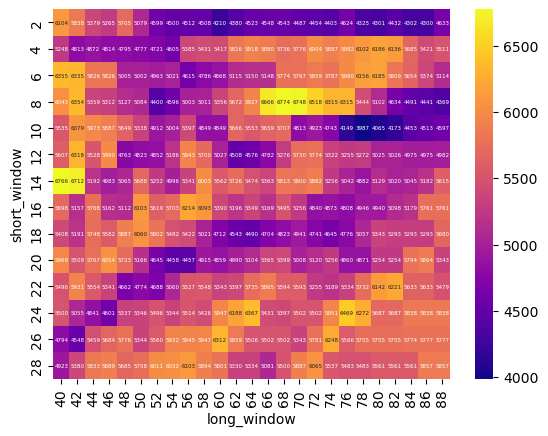

In [15]:
# Plot the heatmap
hm = heatmap.groupby(["short_window","long_window"]).mean().unstack()
sns.heatmap(hm, cmap="plasma", annot=True, fmt="0.0f", annot_kws={"size": 4} ) # Show the heatmap with annotation values, to distinguish any subtleties in similar shading

display(stats._strategy, stats) # Present the statistics from the Backtest using the strategy

### Optimisation observations

We use the backtesting optimisation function to determine the optimal values for the short and long windows for the exponentially moving average function.
<br>
From the annotated heatmap above, it can be observed that the optimal value for the chosen stock is when the long window is 68 and the short window is 8.

## RSI Oscillator (Relative Strength Index) Trading Algorithm - Optimisation

In [16]:
# Fetch historical price data for the specified stock using yfinance
stock_ohlc_df = yf.download(stock_symbol, start=start_date, end=end_date)

# Review the dataframe
display(stock_ohlc_df.head())
display(stock_ohlc_df.tail())

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-19,112.629997,113.190002,109.629997,110.040001,95.523911,6915400
2018-12-20,110.199997,111.930000,109.199997,110.209999,95.671486,8468300
2018-12-21,110.959999,114.160004,108.809998,109.419998,94.985687,13263600
2018-12-24,110.129997,111.089996,105.959999,106.029999,92.042892,3354000
2018-12-26,106.220001,108.440002,105.029999,108.330002,94.039505,4537000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-11,167.440002,168.130005,166.460007,167.820007,167.820007,6912600
2023-12-12,169.279999,169.279999,167.710007,168.470001,168.470001,4515800
2023-12-13,168.539993,172.050003,168.119995,172.009995,172.009995,6082100
2023-12-14,171.649994,171.970001,167.940002,168.250000,168.250000,7119300
2023-12-15,167.449997,168.509995,166.449997,167.000000,167.000000,17731300


In [17]:
# Define the number of periods (in days) for the RSI windows calculations
rsi_window_size = 14 

# Set the RSI upper and lower boundaries.  RSI is considered overbought when above 70 (ie sell signal) and oversold when below 30 (ie buy signal).
rsi_lower_bound = 30
rsi_upper_bound = 70

In [18]:
# Define an RsiOscillator cross-over strategy for Backtesting.

# According to Investopedia, https://www.investopedia.com/articles/active-trading/042114/overbought-or-oversold-use-relative-strength-index-find-out.asp
# The relative strength index (RSI) is a momentum indicator that measures recent price changes as it moves between 0 and 100.
# The RSI provides short-term buy and sell signals and is used to track the overbought and oversold levels of an asset.
# Low RSI levels, below 30, generate buy signals and indicate an oversold or undervalued condition.
# High RSI levels, above 70, generate sell signals and suggest that a security is overbought or overvalued.
# A reading of 50 denotes a neutral level or balance between bullish and bearish positions.
# Since some assets are more volatile and move quicker than others, the values of 80 and 20 are also frequently used levels
# for overbought and oversold assets.
# WARNING!: Results from the RSI may be misleading when markets are trending so it should only be used during a ranging market.

class RsiOscillator(Strategy):

    # Set up parameters to RSI ****************** TO DO: USE SAME VALUES FROM PREVIOUS CELLS FAR BACK
    global rsi_upper_bound # Access the global RSI upper limit which triggers a sell
    global rsi_lower_bound # Access the global RSI lower limit which triggers a buy
    global rsi_window_size # Access the global rolling window size used by the RSI algorithm

    upper_bound = rsi_upper_bound # Assign the global RSI upper limit which triggers a sell to the local class
    lower_bound = rsi_lower_bound # Access the global RSI lower limit which triggers a buy
    rsi_window = rsi_window_size # Access the global rolling window size used by the RSI algorithm

    
    # Do as much initial computation as possible
    def init(self):
        self.rsi = self.I(ta.rsi, pd.Series(self.data.Close), self.rsi_window)

    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()
          


In [19]:
# Run a Backtest Simulation Using an RsiScillator cross over strategy, with $10,000 available funds and 0.2% trading fee commission
bt = Backtest(stock_ohlc_df, RsiOscillator, cash=10000, commission=0.002)

stats = bt.run()
bt.plot()
display(stats._strategy, stats) # Present the statistics from the Backtest using the strategy

C:\Users\prajw\Anaconda3\envs\dev\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\prajw\Anaconda3\envs\dev\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


<Strategy RsiOscillator>

Start                     2018-12-19 00:00:00
End                       2023-12-15 00:00:00
Duration                   1822 days 00:00:00
Exposure Time [%]                   44.709626
Equity Final [$]                 12657.389522
Equity Peak [$]                  14468.640208
Return [%]                          26.573895
Buy & Hold Return [%]               51.762994
Return (Ann.) [%]                    4.837747
Volatility (Ann.) [%]               19.543093
Sharpe Ratio                         0.247543
Sortino Ratio                        0.373274
Calmar Ratio                         0.180452
Max. Drawdown [%]                  -26.808991
Avg. Drawdown [%]                   -3.878685
Max. Drawdown Duration      197 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                    4
Win Rate [%]                             75.0
Best Trade [%]                      17.680372
Worst Trade [%]                     -8.609994
Avg. Trade [%]                    

C:\Users\prajw\Anaconda3\envs\dev\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 630 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

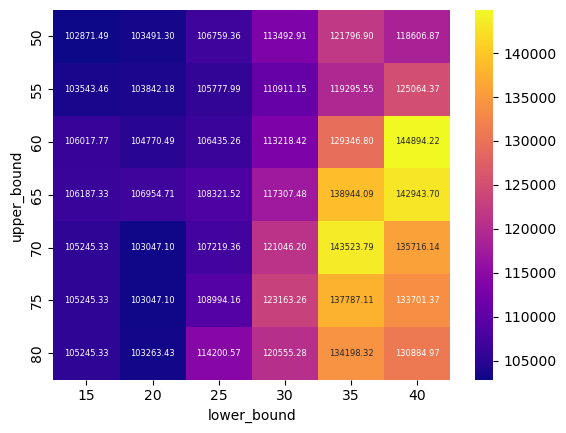

<Strategy RsiOscillator(upper_bound=60,lower_bound=40,rsi_window=20)>

Start                     2018-12-19 00:00:00
End                       2023-12-15 00:00:00
Duration                   1822 days 00:00:00
Exposure Time [%]                   44.470963
Equity Final [$]                169753.324743
Equity Peak [$]                 183712.463507
Return [%]                          69.753325
Buy & Hold Return [%]               51.762994
Return (Ann.) [%]                   11.191952
Volatility (Ann.) [%]               20.657706
Sharpe Ratio                         0.541781
Sortino Ratio                        0.883977
Calmar Ratio                         0.414373
Max. Drawdown [%]                  -27.009351
Avg. Drawdown [%]                   -3.012864
Max. Drawdown Duration      208 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                   12
Win Rate [%]                        91.666667
Best Trade [%]                       9.361432
Worst Trade [%]                     -6.356741
Avg. Trade [%]                    

In [20]:
# Set up for the back test using the RSI Oscillator

bt = Backtest(stock_ohlc_df, RsiOscillator, cash=100000, commission=.002)

stats, heatmap = bt.optimize(           # Run the optimizer...
        upper_bound = range(50,85,5),   # Test upper bound combinations starting from 50 to 85 in increments of 5
        lower_bound = range(15,45,5),   # Test lower bound combinations starting from 15 to 45 in increments of 5
        rsi_window = range(10,40,2),    # Test RSI Window size combinations starting from 10 to 40 days in increments of 2
        maximize='Equity Final [$]',
        return_heatmap=True)

# Plot the heatmap
hm = heatmap.groupby(["upper_bound","lower_bound"]).mean().unstack()
sns.heatmap(hm, cmap="plasma", annot=True, fmt="0.2f", annot_kws={"size": 6} ) # Show the heatmap with annotation values, to distinguish any subtleties in similar shading
plt.show()

display(stats._strategy, stats) # Present the statistics from the Backtest using the strategy

### Optimisation observations

We use the Backtesting Optimisation function to explore the best combination of RSI upper bound (between 50 and 85 in increments of 5), RSI lower bound (between 15 and 45 in increments of 5), and the RSI Window size (between 10 and 40 in increments of 2).

Amongst the 630 different combinations thus generated, the modeller determined, by a slim margin, that the upper/lower bounds of 60/40 yielded the best results, followed by 65/40, and 70/35.  

However we need to determine the optimal RSI window size which is not plotted by default. Further heatmaps are presented below to show combinations of other dimentions.

Since our strategy contains several parameters, we might be interested in other relationships between their values. We can use backtesting.lib.plot_heatmaps() function to plot interactive heatmaps of all parameter combinations simultaneously.

In [21]:
# Present the other dimension combinations we attempted to optimise
from backtesting.lib import plot_heatmaps
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p1486', ...)

### Further observations
The optimal RSI Window size vs Upper Bound is at 38 (days) and 65 RSI, with a score of 149503.525 observed by hovering over the above central heat map.   
However the optimal lower bound of 40 is achieved with an RSI Window of 14 (days).   

This implies we would need to adopt two separate RSI oscillators, one using a 38 day window which triggers a sell if the RSI crosses 65, and 14 window which we would check the lower bounds crossing below 40 for a buy signal. This is technically feasible, but has been left for another day due to time constraints. 